In [8]:
from numpy import linalg
def rbf_kernel(u, v, gamma=0.1):
    return np.exp(-(gamma)*(linalg.norm(u-v)**2))     
import cvxopt
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin
class MySVM(BaseEstimator, ClassifierMixin):
     def __init__(self, kernel=rbf_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    def fit(self, X, y=None):
        m_samples, n_features = X.shape
        K = np.zeros((m_samples, m_samples))
        for i in range(m_samples):
            for j in range(m_samples):
                K[i,j] = self.kernel(X[i], X[j])
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(m_samples) * -1)
        A = cvxopt.matrix(y, (1,m_samples))
        b = cvxopt.matrix(0.0)
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(m_samples) * -1))
            h = cvxopt.matrix(np.zeros(m_samples))
        else:
            tmp1 = np.diag(np.ones(m_samples) * -1)
            tmp2 = np.identity(m_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(m_samples)
            tmp2 = np.ones(m_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        a = np.ravel(solution['x'])
        sv = a > 1e-3
        indices = []
        for t in range(len(sv)):
          if sv[t]:
            indices.append(t)
        self.a = a[sv]
        self.y_sv = y[sv] 
        self.support_vectors_ = X[sv] 
        print("%d support vectors out of %d points" % (sum(sv), m_samples))
        self.b = 0
        for k in range(sum(sv)):
           self.b = self.b + self.y_sv[k] - np.sum(K[indices[k],sv] * self.a*self.y_sv) 
                self.b = self.b/sum(sv) 
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for k in range(sum(sv)):
              self.w = self.w + self.a[k] * self.y_sv[k] * self.support_vectors_[k]
        else:
            self.w =  None
    def decision_function(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))    
            for i in range(len(X)):
              sum = 0
              for j in range(len(self.support_vectors_)):
                 sum = sum + self.a[j] * self.y_sv[j] * self.kernel(X[i],self.support_vectors_[j])
              y_predict[i] = sum + self.b
            return y_predict
    def predict(self, X):
        return np.sign(self.decision_function(X))

In [13]:
import matplotlib.pyplot as plt

def plot_svm (clf, X, y, axes=[-2, 3, -2, 2]):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s,x1s)
    X_mesh = np.c_[x0.ravel(), x1.ravel()] 
    y_pred = clf.predict(X_mesh).reshape(x0.shape)
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figsize=(16, 9)
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "bo", label="Class -1")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "go", label="Class +1")
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=80, c="r", label="Support Vectors")
    plt.contourf(x0,x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)
    plt.contourf(x0,x1, y_decision, cmap = plt.cm.brg, alpha = 0.2)
    plt.contour(x0, x1, y_decision, colors='k',
                 levels=[-1, 0, 1], alpha=0.5,
                 linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")

    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0) 


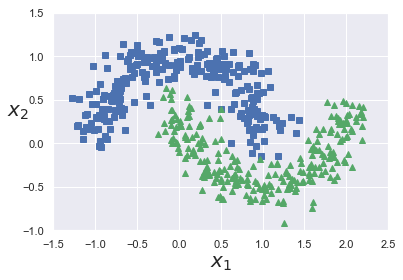

     pcost       dcost       gap    pres   dres
 0: -1.8344e+02 -1.7302e+03  5e+03  1e+00  5e-15
 1: -1.4223e+02 -6.7136e+02  5e+02  3e-15  4e-15
 2: -1.8732e+02 -2.9502e+02  1e+02  8e-15  4e-15
 3: -2.1282e+02 -2.4713e+02  3e+01  9e-16  4e-15
 4: -2.1845e+02 -2.3860e+02  2e+01  8e-15  5e-15
 5: -2.2254e+02 -2.3164e+02  9e+00  4e-15  4e-15
 6: -2.2431e+02 -2.2887e+02  5e+00  5e-15  4e-15
 7: -2.2545e+02 -2.2733e+02  2e+00  4e-15  5e-15
 8: -2.2599e+02 -2.2664e+02  6e-01  4e-15  5e-15
 9: -2.2627e+02 -2.2629e+02  2e-02  1e-14  5e-15
10: -2.2628e+02 -2.2628e+02  5e-04  1e-14  5e-15
11: -2.2628e+02 -2.2628e+02  1e-05  6e-15  6e-15
Optimal solution found.
130 support vectors out of 400 points
Classification report: 
              precision    recall  f1-score   support

        -1.0       0.88      0.78      0.82        45
         1.0       0.83      0.91      0.87        55

    accuracy                           0.85       100
   macro avg       0.85      0.84      0.85       100
weight

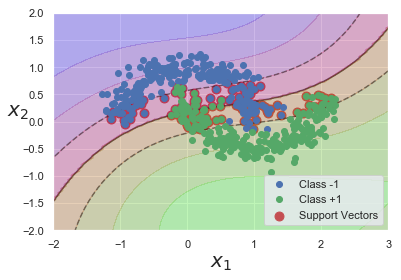

In [14]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.datasets import make_moons
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons (n_samples = 500, noise = 0.15, random_state = 49)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X,y,[-1.5, 2.5, -1, 1.5])
plt.show()

y = y*2-1.0 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
svm_rbfmy = MySVM(kernel=rbf_kernel,C=2)
svm_rbfmy.fit(X_train, y_train)
expected = y_test
predicted = svm_rbfmy.predict(X_test)
cm = confusion_matrix(expected, predicted)
print("Classification report: \n%s\n" % (metrics.classification_report(expected, predicted)))    
print("Confusion matrix:\n%s" % cm)
print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))
plot_svm(svm_rbfmy,X,y)

In [ ]:
svm_rbfmy = MySVM(kernel=rbf_kernel,C=2)
svm_rbfmy.fit(X_train, y_train)
expected = y_test
predicted = svm_rbfmy.predict(X_test)